In [1]:
%matplotlib inline
!git pull
# import os;os.environ['LAMBDA_PARQUET_TICK_DB']=rf'X:\lambda_data'


Already up to date.


# Generation
Is generating running a backtest where the replay buffer is also going to save prices the time_horizon_seconds later to try to get a dataframe to get most important features.
Private  states are always included(inventory + score) so in the backtest the trades are not changing the results

In [2]:
from notebooks.lambda_imports import *

PROJECT_PATH=E:\javif\Coding\Python\market_making_fw\python_lambda
BACKTEST_OUTPUT_PATH(LAMBDA_OUTPUT_PATH)=X:\output_models
BACKTEST_TEMP_PATH(LAMBDA_TEMP_PATH)=E:\javif\Coding\Python\market_making_fw\java\temp;
BACKTEST_JAR_PATH(LAMBDA_JAR_PATH)=E:\javif\Coding\Python\market_making_fw\java\executables\Backtest\target\Backtest.jar
log_path(LAMBDA_LOGS_PATH)=E:\javif\Coding\Python\market_making_fw\python_lambda\logs
PARQUET_PATH_DB(LAMBDA_PARQUET_TICK_DB)=X:\


In [3]:
columns_to_take_pct = 0.35
time_horizon_seconds=5
##
tick = TickDB()
instrument_pk='btcusdt_binance'
start_date=datetime.datetime(year=2020, day=7, month=12)
end_date=datetime.datetime(year=2020, day=7, month=12)
MARKET_MIDPRICE_RELATIVE=True
private_horizon_ticks=5#always included
market_horizon_ticks=10
candle_horizon=5

In [4]:
seed_number=28220
np.random.seed(seed_number)
import random
random.seed(seed_number)

In [5]:
from mlfinlab.feature_importance import single_feature_importance, mean_decrease_impurity, mean_decrease_accuracy, \
    plot_feature_importance, get_orthogonal_features, feature_pca_analysis


In [6]:
FILENAME = (BACKTEST_OUTPUT_PATH + '/ReplayBuffer_feature_importance_candles.csv')
session_filename='feature_importance.db'
GENERATE_FILE=True

In [7]:
# dill.load_session(session_filename)
depth_data = tick.get_depth(instrument_pk=instrument_pk,start_date=start_date,end_date=end_date)
trade_data = tick.get_trades(instrument_pk=instrument_pk,start_date=start_date,end_date=end_date)
candle_data = tick.get_candles_time(instrument_pk=instrument_pk,start_date=start_date,end_date=end_date)

downloading btcusdt_binance depth from 20201207 to 20201207
downloading btcusdt_binance trade from 20201207 to 20201207
downloading btcusdt_binance candle_time_MIN1 from 20201207 to 20201207


In [8]:
candle_data

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,date
datetime,,,,,,,,,,,
2020-12-07 00:00:00,1607299200,46144,19379.65,19380.21,19350.22,19359.40,30.934428,13.630868,510,5.991715e+05,20201207
2020-12-07 00:01:00,1607299260,47017,19358.67,19398.99,19358.67,19387.06,61.024367,46.589752,873,1.183011e+06,20201207
2020-12-07 00:02:00,1607299320,47803,19387.50,19387.50,19360.01,19369.49,38.854822,18.274619,786,7.528354e+05,20201207
2020-12-07 00:03:00,1607299380,48785,19369.49,19420.00,19353.75,19413.61,108.528470,73.638152,982,2.105169e+06,20201207
2020-12-07 00:04:00,1607299440,49559,19413.61,19420.91,19406.59,19410.58,68.898391,38.462748,774,1.337736e+06,20201207
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-07 22:55:00,1607381700,553268,19097.33,19109.52,19094.99,19107.43,19.979734,14.427726,573,3.816763e+05,20201207
2020-12-07 22:56:00,1607381760,553905,19108.30,19110.00,19102.68,19109.01,12.829644,6.992196,637,2.451492e+05,20201207
2020-12-07 22:57:00,1607381820,554258,19109.01,19110.00,19103.77,19110.00,8.734797,4.908696,353,1.669069e+05,20201207


In [9]:
# import plotly.graph_objects as go

# candlestick = go.Candlestick(
#     x=candle_data.index,
#     open=candle_data['open'],
#     high=candle_data['high'],
#     low=candle_data['low'],
#     close=candle_data['close']
# )

# fig = go.Figure(data=[candlestick])
# fig.show()

In [10]:
columns_states = []

private_states=[]
market__depth_states = []
market__trade_states = []
candle_states = []
#   [inventory_2, inventory_1, inventory_0,
#   score_2, score_1, score_0,
for private_state_horizon in range(private_horizon_ticks-1,-1,-1):
    private_states.append('inventory_%d'%private_state_horizon)
    private_states.append('score_%d'%private_state_horizon)
    
for market_state_horizon in range(market_horizon_ticks-1,-1,-1):
    market__depth_states.append('bid_price_%d'%market_state_horizon)
    market__depth_states.append('ask_price_%d'%market_state_horizon)
    market__depth_states.append('bid_qty_%d'%market_state_horizon)
    market__depth_states.append('ask_qty_%d'%market_state_horizon)
    market__depth_states.append('spread_%d'%market_state_horizon)
    market__depth_states.append('midprice_%d'%market_state_horizon)
    market__depth_states.append('microprice_%d'%market_state_horizon)
    market__trade_states.append('last_close_price_%d'%market_state_horizon)
    market__trade_states.append('last_close_qty_%d'%market_state_horizon)
for candle_state_horizon in range(candle_horizon-1,-1,-1):
  if not MARKET_MIDPRICE_RELATIVE:
    candle_states.append('open_%d'%candle_state_horizon)
  candle_states.append('high_%d'%candle_state_horizon)
  candle_states.append('low_%d'%candle_state_horizon)
  candle_states.append('close_%d'%candle_state_horizon)
candle_states.append('ma')
candle_states.append('std')
candle_states.append('max')
candle_states.append('min')



future_columns = ['future_midprice', 'future_askprice', 'future_bidprice']

columns_states=private_states+market__depth_states+market__trade_states+candle_states
columns_states += future_columns

In [11]:
# MARKET_MIDPRICE_RELATIVE
depth_data['spread']=abs(depth_data['bidPrice0']-depth_data['askPrice0'])
depth_data['midprice']=(depth_data['bidPrice0']+depth_data['askPrice0'])/2
depth_data['microprice']=get_microprice(depth_data)
depth_data['imbalance']=get_imbalance(depth_data,max_depth=5)

if MARKET_MIDPRICE_RELATIVE:
    depth_data['bidPrice0']=abs(depth_data['bidPrice0']-depth_data['midprice'])
    depth_data['askPrice0']=abs(depth_data['askPrice0']-depth_data['midprice'])
    depth_data['microprice']=abs(depth_data['microprice']-depth_data['midprice'])

for lag in range(market_horizon_ticks):
    depth_data['bid_price_%d'%lag]=depth_data['bidPrice0'].shift(lag)
    depth_data['ask_price_%d'%lag]=depth_data['askPrice0'].shift(lag)
    depth_data['bid_qty_%d'%lag]=depth_data['bidQuantity0'].shift(lag)
    depth_data['ask_qty_%d'%lag]=depth_data['askQuantity0'].shift(lag)
    depth_data['spread_%d'%lag]=depth_data['spread'].shift(lag)
    depth_data['midprice_%d'%lag]=depth_data['midprice'].shift(lag)
    depth_data['microprice_%d'%lag]=depth_data['microprice'].shift(lag)

depth_data.tail()

,askPrice0,askPrice1,askPrice2,askPrice3,askPrice4,askQuantity0,askQuantity1,askQuantity2,askQuantity3,askQuantity4,bidPrice0,bidPrice1,bidPrice2,bidPrice3,bidPrice4,bidQuantity0,bidQuantity1,bidQuantity2,bidQuantity3,bidQuantity4,midprice,spread,microprice,imbalance,bid_price_0,...,ask_qty_6,spread_6,midprice_6,microprice_6,bid_price_7,ask_price_7,bid_qty_7,ask_qty_7,spread_7,midprice_7,microprice_7,bid_price_8,ask_price_8,bid_qty_8,ask_qty_8,spread_8,midprice_8,microprice_8,bid_price_9,ask_price_9,bid_qty_9,ask_qty_9,spread_9,midprice_9,microprice_9
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-07 22:59:52.856,0.005,19114.79,19114.98,19114.99,19115.68,0.964469,0.097590,0.773956,0.026157,0.061266,0.005,19113.95,19113.84,19112.95,19110.11,10.225415,0.000575,4.738066,0.075924,0.200000,19114.035,0.01,0.004989,0.827618,0.005,...,12.940981,0.01,19113.845,0.003344,0.005,0.005,5.799824,4.104273,0.01,19113.845,0.000873,0.005,0.005,6.286044,4.469543,0.01,19113.845,0.000686,0.005,0.005,5.714493,2.114133,0.01,19113.865,0.004958
2020-12-07 22:59:53.856,0.005,19114.22,19114.98,19117.88,19118.52,3.230739,0.137693,1.324950,1.748000,0.017000,0.005,19113.93,19113.91,19113.85,19113.84,9.648370,0.000575,0.000575,0.000693,4.676666,19114.035,0.01,0.004994,0.498298,0.005,...,3.322172,0.01,19113.845,0.003328,0.005,0.005,5.834448,12.940981,0.01,19113.845,0.003344,0.005,0.005,5.799824,4.104273,0.01,19113.845,0.000873,0.005,0.005,6.286044,4.469543,0.01,19113.845,0.000686
2020-12-07 22:59:54.856,0.005,19114.98,19114.99,19116.28,19117.90,1.367300,0.141252,0.026157,0.103000,0.114279,0.005,19113.84,19113.10,19109.83,19109.70,9.666863,4.677241,0.000575,0.050000,0.070234,19114.035,0.01,0.003321,0.752170,0.005,...,2.240768,0.01,19114.985,0.004159,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,5.834448,12.940981,0.01,19113.845,0.003344,0.005,0.005,5.799824,4.104273,0.01,19113.845,0.000873
2020-12-07 22:59:56.856,0.005,19114.23,19114.98,19114.99,19117.17,1.659582,0.000043,0.141252,0.953784,0.104000,0.005,19114.03,19111.62,19109.82,19103.55,5.298464,0.005500,0.013081,0.800000,0.125000,19114.175,0.01,0.004044,0.522975,0.005,...,2.431178,0.01,19114.985,0.001064,0.005,0.005,2.661987,2.240768,0.01,19114.985,0.004159,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,5.834448,12.940981,0.01,19113.845,0.003344
2020-12-07 22:59:57.857,0.005,19114.99,19117.27,19118.46,19120.15,0.918936,0.026157,0.114279,0.050000,0.723000,0.005,19110.49,19110.11,19108.82,19108.44,2.824490,0.050000,0.200000,0.800000,1.617000,19114.485,0.01,0.004663,0.509040,0.005,...,2.284575,0.01,19114.595,0.004948,0.005,0.005,1.105365,2.431178,0.01,19114.985,0.001064,0.005,0.005,2.661987,2.240768,0.01,19114.985,0.004159,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328


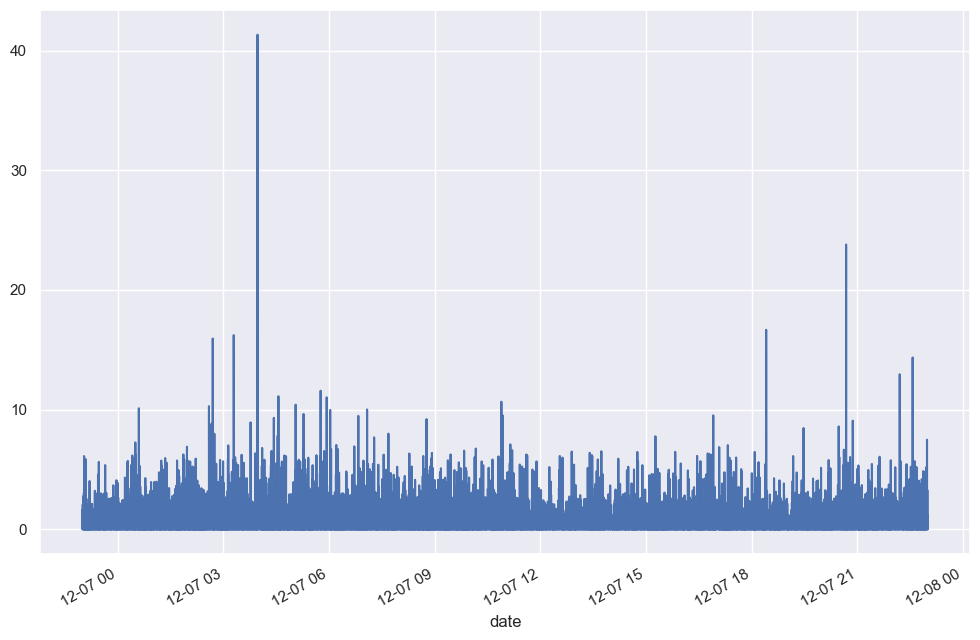

In [12]:
depth_data['ask_price_1'].plot()
plt.show()

In [13]:
#add future
future_df=pd.DataFrame(columns=future_columns)
future_df['future_midprice']=copy.copy(depth_data['midprice'].shift(periods=-time_horizon_seconds,freq="S"))
future_df['future_askprice']=copy.copy(depth_data['askPrice0'].shift(periods=-time_horizon_seconds,freq="S"))
future_df['future_bidprice']=copy.copy(depth_data['bidPrice0'].shift(periods=-time_horizon_seconds,freq="S"))

future_df.head()

,future_midprice,future_askprice,future_bidprice
date,,,
2020-12-06 22:59:43.342,19129.065,2.055,2.055
2020-12-06 22:59:44.342,19129.735,0.005,0.005
2020-12-06 22:59:46.342,19129.735,0.005,0.005
2020-12-06 22:59:47.342,19129.715,0.005,0.005
2020-12-06 22:59:48.343,19129.695,0.005,0.005


In [14]:
for lag in range(market_horizon_ticks):
    trade_data['last_close_price_%d'%lag]=trade_data['price'].shift(lag)
    trade_data['last_close_qty_%d'%lag]=trade_data['quantity'].shift(lag)

In [15]:
MARKET_MIDPRICE_RELATIVE

True

In [16]:
import copy
candle_data_2 = copy.copy(candle_data)
if MARKET_MIDPRICE_RELATIVE:    
    candle_data_2['close']=(candle_data_2['close']/candle_data_2['open'])-1.0
    candle_data_2['low']=(candle_data_2['low']/candle_data_2['open'])-1.
    candle_data_2['high']=(candle_data_2['high']/candle_data_2['open'])-1.
    candle_data_2.drop(columns=['open'],inplace=True)
    
    
for lag in range(candle_horizon):
#     candle_data['open_%d'%lag]=candle_data['price_open'].shift(lag)
    candle_data_2['close_%d'%lag]=candle_data_2['close'].shift(lag)
    candle_data_2['low_%d'%lag]=candle_data_2['low'].shift(lag)
    candle_data_2['high_%d'%lag]=candle_data_2['high'].shift(lag)

candle_data_2['ma'] = candle_data_2['close'].rolling(window=candle_horizon).mean()
candle_data_2['std'] = candle_data_2['close'].rolling(window=candle_horizon).std()
candle_data_2['max'] = candle_data_2['high'].rolling(window=candle_horizon).max()
candle_data_2['min'] = candle_data_2['low'].rolling(window=candle_horizon).min()
candle_data_2.tail(15)

,date_time,tick_num,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,date,close_0,low_0,high_0,close_1,low_1,high_1,close_2,low_2,high_2,close_3,low_3,high_3,close_4,low_4,high_4,ma,std,max,min
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-12-07 22:45:00,1607381100,549754,1.241152e-04,-0.000226,-0.000007,4.517348,2.157829,270,86257.979941,20201207,-0.000007,-0.000226,1.241152e-04,0.000483,-0.000151,6.041397e-04,0.000035,-0.000354,1.220844e-04,-0.000116,-0.000305,2.043236e-05,0.000040,-0.000180,2.006688e-04,0.000087,0.000230,0.000604,-0.000354
2020-12-07 22:46:00,1607381160,550073,2.723254e-04,-0.000190,0.000066,3.735018,1.817194,319,71325.059377,20201207,0.000066,-0.000190,2.723254e-04,-0.000007,-0.000226,1.241152e-04,0.000483,-0.000151,6.041397e-04,0.000035,-0.000354,1.220844e-04,-0.000116,-0.000305,2.043236e-05,0.000092,0.000229,0.000604,-0.000354
2020-12-07 22:47:00,1607381220,550302,1.602351e-04,-0.000023,0.000159,2.863874,1.717285,229,54695.517162,20201207,0.000159,-0.000023,1.602351e-04,0.000066,-0.000190,2.723254e-04,-0.000007,-0.000226,1.241152e-04,0.000483,-0.000151,6.041397e-04,0.000035,-0.000354,1.220844e-04,0.000147,0.000197,0.000604,-0.000354
2020-12-07 22:48:00,1607381280,550651,2.638749e-04,-0.000001,0.000234,3.882453,2.163920,349,74160.609698,20201207,0.000234,-0.000001,2.638749e-04,0.000159,-0.000023,1.602351e-04,0.000066,-0.000190,2.723254e-04,-0.000007,-0.000226,1.241152e-04,0.000483,-0.000151,6.041397e-04,0.000187,0.000189,0.000604,-0.000226
2020-12-07 22:49:00,1607381340,550919,5.234388e-07,-0.000489,-0.000224,7.524861,2.898900,268,143718.279347,20201207,-0.000224,-0.000489,5.234388e-07,0.000234,-0.000001,2.638749e-04,0.000159,-0.000023,1.602351e-04,0.000066,-0.000190,2.723254e-04,-0.000007,-0.000226,1.241152e-04,0.000045,0.000176,0.000272,-0.000489
2020-12-07 22:50:00,1607381400,551276,0.000000e+00,-0.000426,-0.000338,6.467069,3.100696,357,123496.063210,20201207,-0.000338,-0.000426,0.000000e+00,-0.000224,-0.000489,5.234388e-07,0.000234,-0.000001,2.638749e-04,0.000159,-0.000023,1.602351e-04,0.000066,-0.000190,2.723254e-04,-0.000021,0.000248,0.000272,-0.000489
2020-12-07 22:51:00,1607381460,551639,7.803699e-05,-0.000445,-0.000231,6.506204,2.174040,363,124216.819568,20201207,-0.000231,-0.000445,7.803699e-05,-0.000338,-0.000426,0.000000e+00,-0.000224,-0.000489,5.234388e-07,0.000234,-0.000001,2.638749e-04,0.000159,-0.000023,1.602351e-04,-0.000080,0.000258,0.000264,-0.000489
2020-12-07 22:52:00,1607381520,552059,5.290980e-05,-0.000282,-0.000059,9.080156,5.725155,420,173308.454675,20201207,-0.000059,-0.000282,5.290980e-05,-0.000231,-0.000445,7.803699e-05,-0.000338,-0.000426,0.000000e+00,-0.000224,-0.000489,5.234388e-07,0.000234,-0.000001,2.638749e-04,-0.000124,0.000224,0.000264,-0.000489
2020-12-07 22:53:00,1607381580,552350,4.914090e-04,-0.000037,0.000218,5.502119,3.465596,291,105046.583253,20201207,0.000218,-0.000037,4.914090e-04,-0.000059,-0.000282,5.290980e-05,-0.000231,-0.000445,7.803699e-05,-0.000338,-0.000426,0.000000e+00,-0.000224,-0.000489,5.234388e-07,-0.000127,0.000217,0.000491,-0.000489


In [17]:
depth_data_2 = depth_data[market__depth_states]
trade_data_2 = trade_data[market__trade_states]
candle_data_3 = candle_data_2[candle_states]
future_data_2 = future_df[future_columns]

In [18]:
future_data_2.head()

,future_midprice,future_askprice,future_bidprice
date,,,
2020-12-06 22:59:43.342,19129.065,2.055,2.055
2020-12-06 22:59:44.342,19129.735,0.005,0.005
2020-12-06 22:59:46.342,19129.735,0.005,0.005
2020-12-06 22:59:47.342,19129.715,0.005,0.005
2020-12-06 22:59:48.343,19129.695,0.005,0.005


In [19]:
output_data=pd.concat([depth_data_2,trade_data_2,candle_data_3,future_data_2])
output_data.sort_index(inplace=True)

output_data.fillna(method='ffill',inplace=True,axis=0)
output_data.dropna(inplace=True)
output_data[['midprice_0','future_midprice']]

,midprice_0,future_midprice
2020-12-07 00:04:00.000,19410.575,19411.715
2020-12-07 00:04:00.256,19410.575,19411.715
2020-12-07 00:04:00.536,19410.575,19412.805
2020-12-07 00:04:00.536,19410.015,19412.805
2020-12-07 00:04:00.671,19410.015,19412.805
...,...,...
2020-12-07 22:59:57.923,19114.485,19114.485
2020-12-07 22:59:58.956,19114.485,19114.485
2020-12-07 22:59:58.977,19114.485,19114.485
2020-12-07 22:59:58.994,19114.485,19114.485


In [20]:
output_data.describe()

,bid_price_9,ask_price_9,bid_qty_9,ask_qty_9,spread_9,midprice_9,microprice_9,bid_price_8,ask_price_8,bid_qty_8,ask_qty_8,spread_8,midprice_8,microprice_8,bid_price_7,ask_price_7,bid_qty_7,ask_qty_7,spread_7,midprice_7,microprice_7,bid_price_6,ask_price_6,bid_qty_6,ask_qty_6,...,last_close_qty_1,last_close_price_0,last_close_qty_0,high_4,low_4,close_4,high_3,low_3,close_3,high_2,low_2,close_2,high_1,low_1,close_1,high_0,low_0,close_0,ma,std,max,min,future_midprice,future_askprice,future_bidprice
count,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,...,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,6.633380e+05,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000
mean,0.183727,0.183727,4.370891,4.958341,0.367453,19186.000219,0.142960,0.188302,0.188302,4.375410,4.957799,0.376603,19185.981905,0.146958,0.184868,0.184868,4.365133,4.889287,0.369735,19185.955398,0.144125,0.181479,0.181479,4.357701,4.959203,...,0.056840,19185.655038,0.056744,0.000356,-0.000401,-2.201518e-05,0.000356,-0.000406,-0.000028,0.000355,-0.000401,-0.000024,0.000364,-0.000404,-0.000018,0.000363,-0.000422,-0.000034,-0.000025,0.000539,0.000853,-0.000929,19185.558747,0.183110,0.183110
std,0.672149,0.672149,8.702874,13.810626,1.344298,107.915483,0.523541,0.680976,0.680976,8.473950,13.470744,1.361951,107.926129,0.533529,0.672694,0.672694,8.482319,12.823107,1.345388,107.950436,0.529954,0.662344,0.662344,8.291051,13.693393,...,0.245580,108.088387,0.247242,0.000423,0.000494,6.336845e-04,0.000423,0.000514,0.000656,0.000413,0.000477,0.000618,0.000424,0.000502,0.000643,0.000420,0.000532,0.000671,0.000285,0.000357,0.000536,0.000759,108.211840,0.690676,0.690676
min,0.005000,0.005000,0.002577,0.005504,0.010000,18903.990000,0.000000,0.005000,0.005000,0.002577,0.005504,0.010000,18903.990000,0.000000,0.005000,0.005000,0.002577,0.005504,0.010000,18903.990000,0.000000,0.005000,0.005000,0.002577,0.005504,...,0.000001,18902.880000,0.000001,0.000000,-0.005754,-5.648148e-03,0.000000,-0.005754,-0.005648,0.000000,-0.005754,-0.005648,0.000000,-0.005754,-0.005648,0.000000,-0.005754,-0.005648,-0.001841,0.000043,0.000101,-0.005754,18903.990000,0.005000,0.005000
25%,0.005000,0.005000,1.131113,1.084822,0.010000,19120.005000,0.003145,0.005000,0.005000,1.125084,1.089669,0.010000,19120.005000,0.003148,0.005000,0.005000,1.127884,1.093931,0.010000,19120.005000,0.003156,0.005000,0.005000,1.126198,1.090744,...,0.002627,19120.000000,0.002603,0.000049,-0.000543,-3.129528e-04,0.000050,-0.000553,-0.000314,0.000052,-0.000552,-0.000316,0.000057,-0.000547,-0.000314,0.000058,-0.000582,-0.000348,-0.000149,0.000315,0.000471,-0.001105,19119.055000,0.005000,0.005000
50%,0.005000,0.005000,2.957974,2.984311,0.010000,19206.345000,0.004752,0.005000,0.005000,2.956576,2.982741,0.010000,19206.325000,0.004752,0.005000,0.005000,2.964117,2.984311,0.010000,19206.285000,0.004748,0.005000,0.005000,2.954052,2.989628,...,0.008874,19205.860000,0.008808,0.000224,-0.000273,-5.216481e-07,0.000229,-0.000279,-0.000003,0.000231,-0.000277,-0.000003,0.000234,-0.000279,0.000000,0.000231,-0.000285,0.000000,-0.000015,0.000466,0.000756,-0.000773,19205.885000,0.005000,0.005000
75%,0.005000,0.005000,5.760828,6.251117,0.010000,19253.945000,0.004993,0.005000,0.005000,5.754040,6.257957,0.010000,19253.945000,0.004993,0.005000,0.005000,5.766418,6.219166,0.010000,19253.965000,0.004993,0.005000,0.005000,5.758579,6.237220,...,0.048589,19253.710000,0.048771,0.000490,-0.000091,2.821562e-04,0.000493,-0.000090,0.000288,0.0

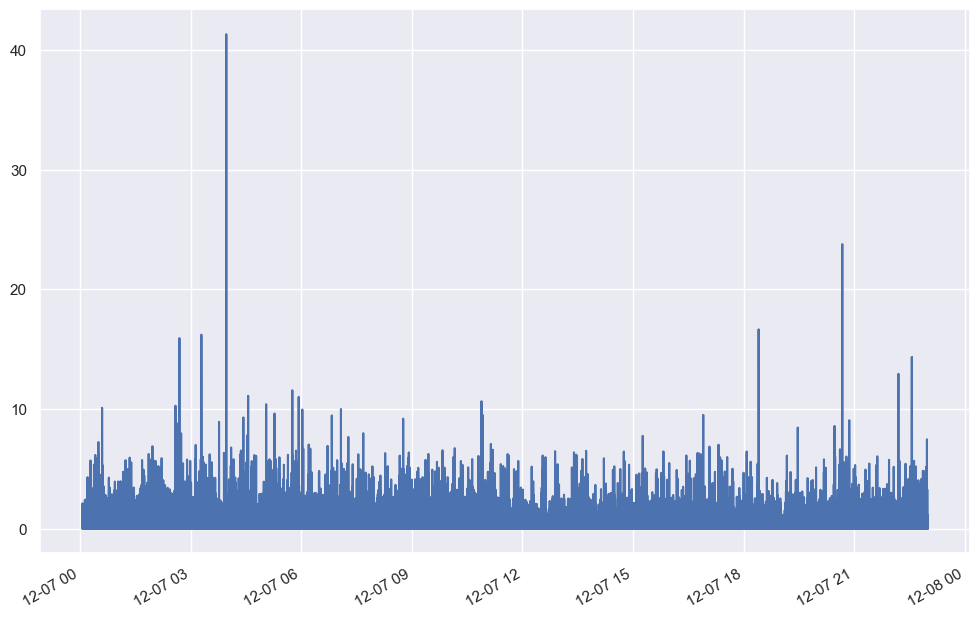

In [21]:
output_data['bid_price_0'].plot()

In [22]:
if GENERATE_FILE:
    output_data.to_csv(FILENAME)

In [23]:
output_data.columns

Index(['bid_price_9', 'ask_price_9', 'bid_qty_9', 'ask_qty_9', 'spread_9',
       'midprice_9', 'microprice_9', 'bid_price_8', 'ask_price_8', 'bid_qty_8',
       ...
       'high_0', 'low_0', 'close_0', 'ma', 'std', 'max', 'min',
       'future_midprice', 'future_askprice', 'future_bidprice'],
      dtype='object', length=112)

# Feature Importance

In [24]:
filename = FILENAME  # (models_path + '/ReplayBufferPrinterAlgo_ethbtc_replaybuffer.csv')
if not GENERATE_FILE:
    output_data = pd.read_csv(FILENAME, index_col=0)
output_data.describe()


,bid_price_9,ask_price_9,bid_qty_9,ask_qty_9,spread_9,midprice_9,microprice_9,bid_price_8,ask_price_8,bid_qty_8,ask_qty_8,spread_8,midprice_8,microprice_8,bid_price_7,ask_price_7,bid_qty_7,ask_qty_7,spread_7,midprice_7,microprice_7,bid_price_6,ask_price_6,bid_qty_6,ask_qty_6,...,last_close_qty_1,last_close_price_0,last_close_qty_0,high_4,low_4,close_4,high_3,low_3,close_3,high_2,low_2,close_2,high_1,low_1,close_1,high_0,low_0,close_0,ma,std,max,min,future_midprice,future_askprice,future_bidprice
count,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,...,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,6.633380e+05,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000
mean,0.183727,0.183727,4.370891,4.958341,0.367453,19186.000219,0.142960,0.188302,0.188302,4.375410,4.957799,0.376603,19185.981905,0.146958,0.184868,0.184868,4.365133,4.889287,0.369735,19185.955398,0.144125,0.181479,0.181479,4.357701,4.959203,...,0.056840,19185.655038,0.056744,0.000356,-0.000401,-2.201518e-05,0.000356,-0.000406,-0.000028,0.000355,-0.000401,-0.000024,0.000364,-0.000404,-0.000018,0.000363,-0.000422,-0.000034,-0.000025,0.000539,0.000853,-0.000929,19185.558747,0.183110,0.183110
std,0.672149,0.672149,8.702874,13.810626,1.344298,107.915483,0.523541,0.680976,0.680976,8.473950,13.470744,1.361951,107.926129,0.533529,0.672694,0.672694,8.482319,12.823107,1.345388,107.950436,0.529954,0.662344,0.662344,8.291051,13.693393,...,0.245580,108.088387,0.247242,0.000423,0.000494,6.336845e-04,0.000423,0.000514,0.000656,0.000413,0.000477,0.000618,0.000424,0.000502,0.000643,0.000420,0.000532,0.000671,0.000285,0.000357,0.000536,0.000759,108.211840,0.690676,0.690676
min,0.005000,0.005000,0.002577,0.005504,0.010000,18903.990000,0.000000,0.005000,0.005000,0.002577,0.005504,0.010000,18903.990000,0.000000,0.005000,0.005000,0.002577,0.005504,0.010000,18903.990000,0.000000,0.005000,0.005000,0.002577,0.005504,...,0.000001,18902.880000,0.000001,0.000000,-0.005754,-5.648148e-03,0.000000,-0.005754,-0.005648,0.000000,-0.005754,-0.005648,0.000000,-0.005754,-0.005648,0.000000,-0.005754,-0.005648,-0.001841,0.000043,0.000101,-0.005754,18903.990000,0.005000,0.005000
25%,0.005000,0.005000,1.131113,1.084822,0.010000,19120.005000,0.003145,0.005000,0.005000,1.125084,1.089669,0.010000,19120.005000,0.003148,0.005000,0.005000,1.127884,1.093931,0.010000,19120.005000,0.003156,0.005000,0.005000,1.126198,1.090744,...,0.002627,19120.000000,0.002603,0.000049,-0.000543,-3.129528e-04,0.000050,-0.000553,-0.000314,0.000052,-0.000552,-0.000316,0.000057,-0.000547,-0.000314,0.000058,-0.000582,-0.000348,-0.000149,0.000315,0.000471,-0.001105,19119.055000,0.005000,0.005000
50%,0.005000,0.005000,2.957974,2.984311,0.010000,19206.345000,0.004752,0.005000,0.005000,2.956576,2.982741,0.010000,19206.325000,0.004752,0.005000,0.005000,2.964117,2.984311,0.010000,19206.285000,0.004748,0.005000,0.005000,2.954052,2.989628,...,0.008874,19205.860000,0.008808,0.000224,-0.000273,-5.216481e-07,0.000229,-0.000279,-0.000003,0.000231,-0.000277,-0.000003,0.000234,-0.000279,0.000000,0.000231,-0.000285,0.000000,-0.000015,0.000466,0.000756,-0.000773,19205.885000,0.005000,0.005000
75%,0.005000,0.005000,5.760828,6.251117,0.010000,19253.945000,0.004993,0.005000,0.005000,5.754040,6.257957,0.010000,19253.945000,0.004993,0.005000,0.005000,5.766418,6.219166,0.010000,19253.965000,0.004993,0.005000,0.005000,5.758579,6.237220,...,0.048589,19253.710000,0.048771,0.000490,-0.000091,2.821562e-04,0.000493,-0.000090,0.000288,0.0

In [25]:
dill.dump_session(session_filename)


In [26]:

assert len(output_data.columns)==len(columns_states)-len(private_states)
output_data.columns

Index(['bid_price_9', 'ask_price_9', 'bid_qty_9', 'ask_qty_9', 'spread_9',
       'midprice_9', 'microprice_9', 'bid_price_8', 'ask_price_8', 'bid_qty_8',
       ...
       'high_0', 'low_0', 'close_0', 'ma', 'std', 'max', 'min',
       'future_midprice', 'future_askprice', 'future_bidprice'],
      dtype='object', length=112)

In [27]:
output_data[['future_midprice','midprice_0']]

,future_midprice,midprice_0
2020-12-07 00:04:00.000,19411.715,19410.575
2020-12-07 00:04:00.256,19411.715,19410.575
2020-12-07 00:04:00.536,19412.805,19410.575
2020-12-07 00:04:00.536,19412.805,19410.015
2020-12-07 00:04:00.671,19412.805,19410.015
...,...,...
2020-12-07 22:59:57.923,19114.485,19114.485
2020-12-07 22:59:58.956,19114.485,19114.485
2020-12-07 22:59:58.977,19114.485,19114.485
2020-12-07 22:59:58.994,19114.485,19114.485


In [28]:
output_data['midprice_diff_future'] = output_data['future_midprice'] - output_data['midprice_0']
output_data['target'] = output_data['midprice_diff_future'] > 0
df=output_data

## Private

In [29]:
# df[state.get_private_columns()].describe()

## Market

In [30]:
df[market__depth_states+market__trade_states].describe()

,bid_price_9,ask_price_9,bid_qty_9,ask_qty_9,spread_9,midprice_9,microprice_9,bid_price_8,ask_price_8,bid_qty_8,ask_qty_8,spread_8,midprice_8,microprice_8,bid_price_7,ask_price_7,bid_qty_7,ask_qty_7,spread_7,midprice_7,microprice_7,bid_price_6,ask_price_6,bid_qty_6,ask_qty_6,...,bid_qty_0,ask_qty_0,spread_0,midprice_0,microprice_0,last_close_price_9,last_close_qty_9,last_close_price_8,last_close_qty_8,last_close_price_7,last_close_qty_7,last_close_price_6,last_close_qty_6,last_close_price_5,last_close_qty_5,last_close_price_4,last_close_qty_4,last_close_price_3,last_close_qty_3,last_close_price_2,last_close_qty_2,last_close_price_1,last_close_qty_1,last_close_price_0,last_close_qty_0
count,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,...,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000
mean,0.183727,0.183727,4.370891,4.958341,0.367453,19186.000219,0.142960,0.188302,0.188302,4.375410,4.957799,0.376603,19185.981905,0.146958,0.184868,0.184868,4.365133,4.889287,0.369735,19185.955398,0.144125,0.181479,0.181479,4.357701,4.959203,...,4.416675,4.970193,0.360667,19185.705297,0.139893,19185.649889,0.057576,19185.650662,0.057598,19185.650609,0.057490,19185.650976,0.057475,19185.651581,0.057409,19185.651129,0.057645,19185.652436,0.057236,19185.653424,0.057070,19185.654199,0.056840,19185.655038,0.056744
std,0.672149,0.672149,8.702874,13.810626,1.344298,107.915483,0.523541,0.680976,0.680976,8.473950,13.470744,1.361951,107.926129,0.533529,0.672694,0.672694,8.482319,12.823107,1.345388,107.950436,0.529954,0.662344,0.662344,8.291051,13.693393,...,8.886811,13.043136,1.348613,108.083004,0.519486,108.089309,0.248924,108.089096,0.249960,108.088701,0.252189,108.087779,0.252879,108.088233,0.252223,108.088095,0.255240,108.088701,0.249975,108.088735,0.248011,108.087704,0.245580,108.088387,0.247242
min,0.005000,0.005000,0.002577,0.005504,0.010000,18903.990000,0.000000,0.005000,0.005000,0.002577,0.005504,0.010000,18903.990000,0.000000,0.005000,0.005000,0.002577,0.005504,0.010000,18903.990000,0.000000,0.005000,0.005000,0.002577,0.005504,...,0.002577,0.005504,0.010000,18903.990000,0.000000,18902.880000,0.000001,18902.880000,0.000001,18902.880000,0.000001,18902.880000,0.000001,18902.880000,0.000001,18902.880000,0.000001,18902.880000,0.000001,18902.880000,0.000001,18902.880000,0.000001,18902.880000,0.000001
25%,0.005000,0.005000,1.131113,1.084822,0.010000,19120.005000,0.003145,0.005000,0.005000,1.125084,1.089669,0.010000,19120.005000,0.003148,0.005000,0.005000,1.127884,1.093931,0.010000,19120.005000,0.003156,0.005000,0.005000,1.126198,1.090744,...,1.109500,1.077489,0.010000,19119.775000,0.003145,19120.000000,0.002688,19120.000000,0.002694,19120.000000,0.002690,19120.000000,0.002670,19120.000000,0.002658,19120.000000,0.002676,19120.000000,0.002666,19120.000000,0.002643,19120.000000,0.002627,19120.000000,0.002603
50%,0.005000,0.005000,2.957974,2.984311,0.010000,19206.345000,0.004752,0.005000,0.005000,2.956576,2.982741,0.010000,19206.325000,0.004752,0.005000,0.005000,2.964117,2.984311,0.010000,19206.285000,0.004748,0.005000,0.005000,2.954052,2.989628,...,2.938858,2.989081,0.010000,19205.935000,0.004751,19205.830000,0.008826,19205.845000,0.008883,19205.850000,0.008862,19205.860000,0.008800,19205.850000,0.008830,19205.850000,0.008935,19205.850000,0.008888,19205.860000,0.008866,19205.860000,0.008874,19205.860000,0.008808
75%,0.005000,0.005000,5.760828,6.251117,0.010000,

## Candles

In [31]:
df[candle_states].describe()

,high_4,low_4,close_4,high_3,low_3,close_3,high_2,low_2,close_2,high_1,low_1,close_1,high_0,low_0,close_0,ma,std,max,min
count,663338.000000,663338.000000,6.633380e+05,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000,663338.000000
mean,0.000356,-0.000401,-2.201518e-05,0.000356,-0.000406,-0.000028,0.000355,-0.000401,-0.000024,0.000364,-0.000404,-0.000018,0.000363,-0.000422,-0.000034,-0.000025,0.000539,0.000853,-0.000929
std,0.000423,0.000494,6.336845e-04,0.000423,0.000514,0.000656,0.000413,0.000477,0.000618,0.000424,0.000502,0.000643,0.000420,0.000532,0.000671,0.000285,0.000357,0.000536,0.000759
min,0.000000,-0.005754,-5.648148e-03,0.000000,-0.005754,-0.005648,0.000000,-0.005754,-0.005648,0.000000,-0.005754,-0.005648,0.000000,-0.005754,-0.005648,-0.001841,0.000043,0.000101,-0.005754
25%,0.000049,-0.000543,-3.129528e-04,0.000050,-0.000553,-0.000314,0.000052,-0.000552,-0.000316,0.000057,-0.000547,-0.000314,0.000058,-0.000582,-0.000348,-0.000149,0.000315,0.000471,-0.001105
50%,0.000224,-0.000273,-5.216481e-07,0.000229,-0.000279,-0.000003,0.000231,-0.000277,-0.000003,0.000234,-0.000279,0.000000,0.000231,-0.000285,0.000000,-0.000015,0.000466,0.000756,-0.000773
75%,0.000490,-0.000091,2.821562e-04,0.000493,-0.000090,0.000288,0.000493,-0.000089,0.000288,0.000512,-0.000087,0.000298,0.000513,-0.000088,0.000299,0.000133,0.000673,0.001110,-0.000508
max,0.003703,0.000000,2.316846e-03,0.003703,0.000000,0.002317,0.003703,0.000000,0.002317,0.003703,0.000000,0.002317,0.003703,0.000000,0.002317,0.000893,0.002671,0.003703,-0.000073


In [32]:
columns_X = list(df.columns[:-7])
X_input = df[columns_X]
y_input = df['target']

In [33]:
y_input.sum()

318306

In [34]:
#Parameter tuning
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
best_model_params=None
split_iloc=int(len(X_input)*0.7)

X_input_parameter=X_input.replace([np.inf, -np.inf], np.nan)
X_input_parameter=X_input_parameter.dropna()

X_train_parameter = X_input.iloc[:split_iloc]
X_test_parameter = X_input.iloc[split_iloc:]
y_train_parameter = y_input.iloc[:split_iloc]
y_test_parameter=  y_input.iloc[split_iloc:]

max_depths=[5,7,10,12,15]
n_estimators=[1,3,5,7,10,20]
best_score_test=-999999
for max_depth in tqdm(max_depths):
    for n_estimator in n_estimators:
        base_est_iter = RandomForestClassifier(n_estimators=n_estimator, criterion='entropy', bootstrap=False,
                                  class_weight='balanced_subsample',n_jobs=-5,max_depth=max_depth)
        base_est_iter.fit(X_train_parameter, y_train_parameter)
        score_test=base_est_iter.score(X_test_parameter,y_test_parameter)
        
        if score_test>best_score_test:
            best_score_test=score_test
            best_depth =max_depth
            best_n_estimator=n_estimator            
            print(f'best params found with max_depth {best_depth} and n_estimator {best_n_estimator} and score test {score_test}')
        

  0%|                                                           | 0/5 [00:00<?, ?it/s]

best params found with max_depth 5 and n_estimator 1 and score test 0.47866353101978876
best params found with max_depth 5 and n_estimator 3 and score test 0.5033467000331655
best params found with max_depth 5 and n_estimator 5 and score test 0.5127184651410539


 40%|████████████████████▍                              | 2/5 [00:35<00:53, 17.88s/it]

best params found with max_depth 10 and n_estimator 1 and score test 0.5128139415684264


 60%|██████████████████████████████▌                    | 3/5 [01:01<00:43, 21.61s/it]

best params found with max_depth 12 and n_estimator 1 and score test 0.5139496085466477


100%|███████████████████████████████████████████████████| 5/5 [02:08<00:00, 25.66s/it]


In [35]:
# %%
print(f'best params found with max_depth {best_depth} and n_estimator {best_n_estimator}')
from sklearn.model_selection import KFold
cv_gen = KFold(n_splits=4)

from sklearn.ensemble import RandomForestClassifier

# base_est = RandomForestClassifier(n_estimators=1, criterion='entropy', bootstrap=False,
#                                   class_weight='balanced_subsample')
base_est = RandomForestClassifier(n_estimators=best_n_estimator, criterion='entropy', bootstrap=False,
                                  class_weight='balanced_subsample',n_jobs=-5,max_depth=best_depth)
# pca_orthog = PCA(n_components=200)

# X_train_orthog = pd.DataFrame(pca_orthog.fit_transform(X_train),index=X_train.index)
X_train_orthog = X_input
y_train = y_input


total_columns = X_train_orthog.shape[1]

columns_to_take_mdi = int(total_columns*columns_to_take_pct*0.25)
columns_to_take_mda = int(total_columns*columns_to_take_pct*0.25)
columns_to_take_sfi = int(total_columns*columns_to_take_pct*0.5)

best params found with max_depth 12 and n_estimator 1


In [36]:
X_train_orthog

,bid_price_9,ask_price_9,bid_qty_9,ask_qty_9,spread_9,midprice_9,microprice_9,bid_price_8,ask_price_8,bid_qty_8,ask_qty_8,spread_8,midprice_8,microprice_8,bid_price_7,ask_price_7,bid_qty_7,ask_qty_7,spread_7,midprice_7,microprice_7,bid_price_6,ask_price_6,bid_qty_6,ask_qty_6,...,last_close_price_3,last_close_qty_3,last_close_price_2,last_close_qty_2,last_close_price_1,last_close_qty_1,last_close_price_0,last_close_qty_0,high_4,low_4,close_4,high_3,low_3,close_3,high_2,low_2,close_2,high_1,low_1,close_1,high_0,low_0,close_0,ma,std
2020-12-07 00:04:00.000,0.005,0.005,0.362480,10.011015,0.01,19415.795,0.004992,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,...,19410.58,0.750000,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.256,0.005,0.005,0.362480,10.011015,0.01,19415.795,0.004992,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,...,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.536,0.005,0.005,0.362480,10.011015,0.01,19415.795,0.004992,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,...,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.536,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,0.01,19406.915,0.000000,0.005,0.005,8.536433,2.352511,...,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.671,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,0.01,19406.915,0.000000,0.005,0.005,8.536433,2.352511,...,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,19410.02,0.000679,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-07 22:59:57.923,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,2.661987,2.240768,0.01,19114.985,0.004159,0.005,0.005,1.105365,2.431178,0.01,19114.985,0.001064,0.005,0.005,0.466500,2.284575,...,19114.18,0.047219,19114.18,0.003544,19114.48,0.001454,19114.49,0.005480,0.000638,-0.000123,0.000529,0.000089,-0.000294,0.000037,0.000052,-0.000274,0.000052,0.000166,-0.000016,0.000084,0.000166,-0.000099,0.000014,0.000143,0.000217
2020-12-07 22:59:58.956,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,2.661987,2.240768,0.01,19114.985,0.004159,0.005,0.005,1.105365,2.431178,0.01,19114.985,0.001064,0.005,0.005,0.466500,2.284575,...,19114.18,0.003544,19114.48,0.001454,19114.49,0.005480,19114.49,0.005734,0.000638,-0.000123,0.000529,0.000089,-0.000294,0.000037,0.000052,-0.000274,0.000052,0.000166,-0.000016,0.000084,0.000166,-0.000099,0.000014,0.000143,0.000217
2020-12-07 22:59:58.977,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,2.6

In [37]:
print('Initially we have %d columns_states that we are going to reduce to a maximun of %d columns'%(X_input.shape[1],columns_to_take_mdi+columns_to_take_mda+columns_to_take_sfi))

Initially we have 107 columns_states that we are going to reduce to a maximun of 36 columns


In [38]:
X_train_orthog=X_train_orthog.replace([np.inf, -np.inf], np.nan)
X_train_orthog=X_train_orthog.dropna()
X_train_orthog

,bid_price_9,ask_price_9,bid_qty_9,ask_qty_9,spread_9,midprice_9,microprice_9,bid_price_8,ask_price_8,bid_qty_8,ask_qty_8,spread_8,midprice_8,microprice_8,bid_price_7,ask_price_7,bid_qty_7,ask_qty_7,spread_7,midprice_7,microprice_7,bid_price_6,ask_price_6,bid_qty_6,ask_qty_6,...,last_close_price_3,last_close_qty_3,last_close_price_2,last_close_qty_2,last_close_price_1,last_close_qty_1,last_close_price_0,last_close_qty_0,high_4,low_4,close_4,high_3,low_3,close_3,high_2,low_2,close_2,high_1,low_1,close_1,high_0,low_0,close_0,ma,std
2020-12-07 00:04:00.000,0.005,0.005,0.362480,10.011015,0.01,19415.795,0.004992,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,...,19410.58,0.750000,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.256,0.005,0.005,0.362480,10.011015,0.01,19415.795,0.004992,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,...,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.536,0.005,0.005,0.362480,10.011015,0.01,19415.795,0.004992,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,...,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.536,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,0.01,19406.915,0.000000,0.005,0.005,8.536433,2.352511,...,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.671,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,0.01,19406.915,0.000000,0.005,0.005,8.536433,2.352511,...,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,19410.02,0.000679,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-07 22:59:57.923,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,2.661987,2.240768,0.01,19114.985,0.004159,0.005,0.005,1.105365,2.431178,0.01,19114.985,0.001064,0.005,0.005,0.466500,2.284575,...,19114.18,0.047219,19114.18,0.003544,19114.48,0.001454,19114.49,0.005480,0.000638,-0.000123,0.000529,0.000089,-0.000294,0.000037,0.000052,-0.000274,0.000052,0.000166,-0.000016,0.000084,0.000166,-0.000099,0.000014,0.000143,0.000217
2020-12-07 22:59:58.956,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,2.661987,2.240768,0.01,19114.985,0.004159,0.005,0.005,1.105365,2.431178,0.01,19114.985,0.001064,0.005,0.005,0.466500,2.284575,...,19114.18,0.003544,19114.48,0.001454,19114.49,0.005480,19114.49,0.005734,0.000638,-0.000123,0.000529,0.000089,-0.000294,0.000037,0.000052,-0.000274,0.000052,0.000166,-0.000016,0.000084,0.000166,-0.000099,0.000014,0.000143,0.000217
2020-12-07 22:59:58.977,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,2.6

In [39]:
X_train_orthog.replace([np.inf, -np.inf], np.nan)

,bid_price_9,ask_price_9,bid_qty_9,ask_qty_9,spread_9,midprice_9,microprice_9,bid_price_8,ask_price_8,bid_qty_8,ask_qty_8,spread_8,midprice_8,microprice_8,bid_price_7,ask_price_7,bid_qty_7,ask_qty_7,spread_7,midprice_7,microprice_7,bid_price_6,ask_price_6,bid_qty_6,ask_qty_6,...,last_close_price_3,last_close_qty_3,last_close_price_2,last_close_qty_2,last_close_price_1,last_close_qty_1,last_close_price_0,last_close_qty_0,high_4,low_4,close_4,high_3,low_3,close_3,high_2,low_2,close_2,high_1,low_1,close_1,high_0,low_0,close_0,ma,std
2020-12-07 00:04:00.000,0.005,0.005,0.362480,10.011015,0.01,19415.795,0.004992,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,...,19410.58,0.750000,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.256,0.005,0.005,0.362480,10.011015,0.01,19415.795,0.004992,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,...,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.536,0.005,0.005,0.362480,10.011015,0.01,19415.795,0.004992,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,...,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.536,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,0.01,19406.915,0.000000,0.005,0.005,8.536433,2.352511,...,19410.57,0.052545,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
2020-12-07 00:04:00.671,0.005,0.005,0.470550,3.761707,0.01,19414.175,0.004967,0.005,0.005,0.519352,3.462578,0.01,19410.125,0.004975,0.005,0.005,0.237109,1.241167,0.01,19406.915,0.000000,0.005,0.005,8.536433,2.352511,...,19410.57,0.060736,19410.58,0.060118,19410.02,0.001476,19410.02,0.000679,0.000029,-0.001519,-0.001045,0.002083,0.000000,0.001467,0.000000,-0.001418,-0.000929,0.002608,-0.000813,0.002278,0.000376,-0.000362,-0.000156,0.000323,0.001483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-07 22:59:57.923,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,2.661987,2.240768,0.01,19114.985,0.004159,0.005,0.005,1.105365,2.431178,0.01,19114.985,0.001064,0.005,0.005,0.466500,2.284575,...,19114.18,0.047219,19114.18,0.003544,19114.48,0.001454,19114.49,0.005480,0.000638,-0.000123,0.000529,0.000089,-0.000294,0.000037,0.000052,-0.000274,0.000052,0.000166,-0.000016,0.000084,0.000166,-0.000099,0.000014,0.000143,0.000217
2020-12-07 22:59:58.956,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,2.661987,2.240768,0.01,19114.985,0.004159,0.005,0.005,1.105365,2.431178,0.01,19114.985,0.001064,0.005,0.005,0.466500,2.284575,...,19114.18,0.003544,19114.48,0.001454,19114.49,0.005480,19114.49,0.005734,0.000638,-0.000123,0.000529,0.000089,-0.000294,0.000037,0.000052,-0.000274,0.000052,0.000166,-0.000016,0.000084,0.000166,-0.000099,0.000014,0.000143,0.000217
2020-12-07 22:59:58.977,0.005,0.005,6.333297,3.322172,0.01,19113.845,0.003328,0.005,0.005,2.6

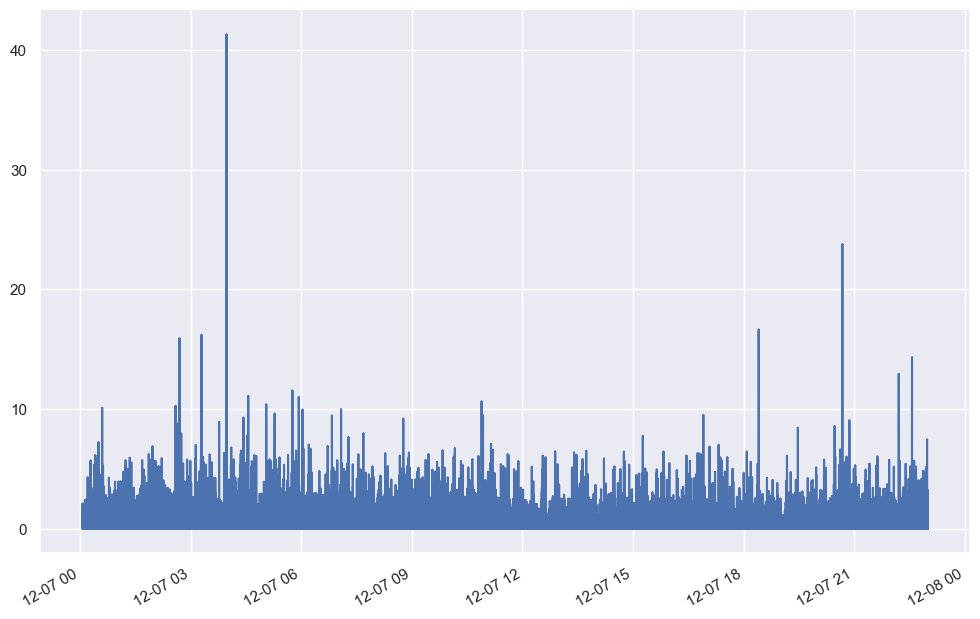

In [40]:
X_train_orthog['bid_price_9'].plot()
plt.show()

In [41]:
y_input.sum()

318306

In [42]:
# %% MDI
# This score can be obtained from tree-based classifiers and corresponds to sklearn’s feature_importances attribute. MDI uses in-sample (IS) performance to estimate feature importance.
print('MDI starting...')
base_est.fit(X_train_orthog, y_input)

mdi_feature_imp = mean_decrease_impurity(base_est, X_train_orthog.columns)
mdi_best_columns = mdi_feature_imp.sort_values(by='mean', ascending=False)[:columns_to_take_mdi].index
mdi_best_columns = list(mdi_best_columns.values)
print(mdi_best_columns)

MDI starting...
['ask_qty_0', 'bid_qty_0', 'ask_price_0', 'ma', 'ask_qty_1', 'bid_price_0', 'low_3', 'ask_qty_4', 'midprice_9']


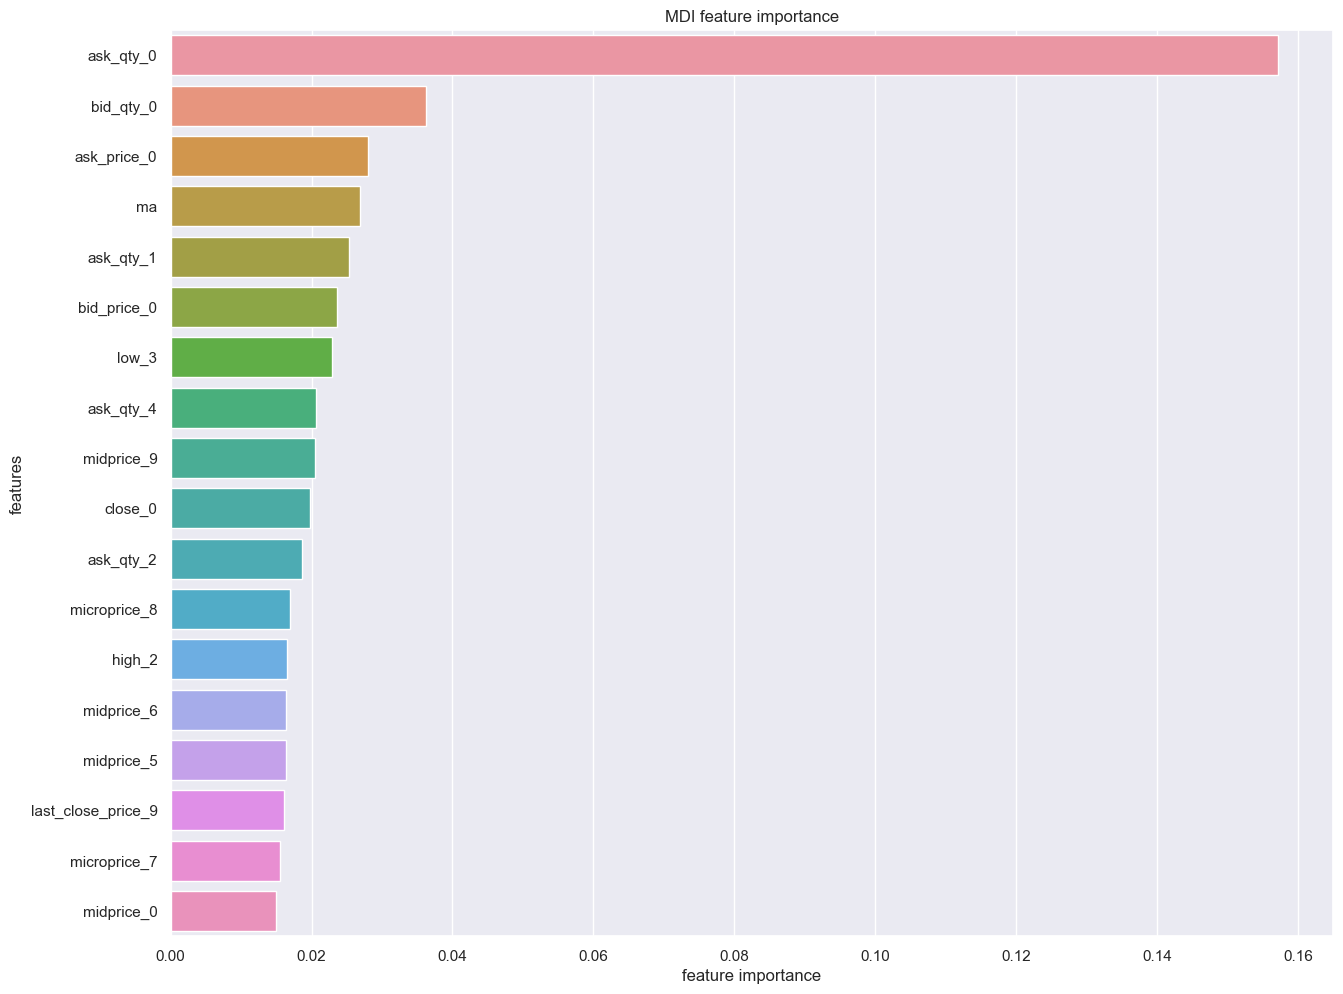

In [43]:
def plot_feature_importance(importance,names,model_type,columns_to_take):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df=fi_df.sort_values(by=['feature_importance'], ascending=False).iloc[:columns_to_take]

    #Define size of bar plot
    plt.figure(figsize=(15,12))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('features')
    plt.show()
    
    
plot_feature_importance(base_est.feature_importances_, X_train_orthog.columns,'MDI',columns_to_take_mdi*2)

In [44]:
# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(base_est.estimators_[0], out_file='tree.dot', 
#                 feature_names = base_est.feature_importances_,
#                 class_names = X_train_orthog.columns,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

In [45]:
# %% MDA
# This method can be applied to any classifier, not only tree based. MDA uses out-of-sample (OOS) performance in order to estimate feature importance.
from sklearn.metrics import accuracy_score, log_loss

print('MDA starting...')
mda_feature_imp = mean_decrease_accuracy(base_est, X_train_orthog, y_input, cv_gen, scoring=log_loss)
mda_best_columns = mda_feature_imp.sort_values(by='mean', ascending=False)[:columns_to_take_mda].index
mda_best_columns = list(mda_best_columns.values)
print(mda_best_columns)


MDA starting...
['last_close_price_4', 'midprice_5', 'midprice_8', 'bid_qty_0', 'last_close_price_5', 'last_close_price_1', 'close_0', 'close_4', 'low_0']


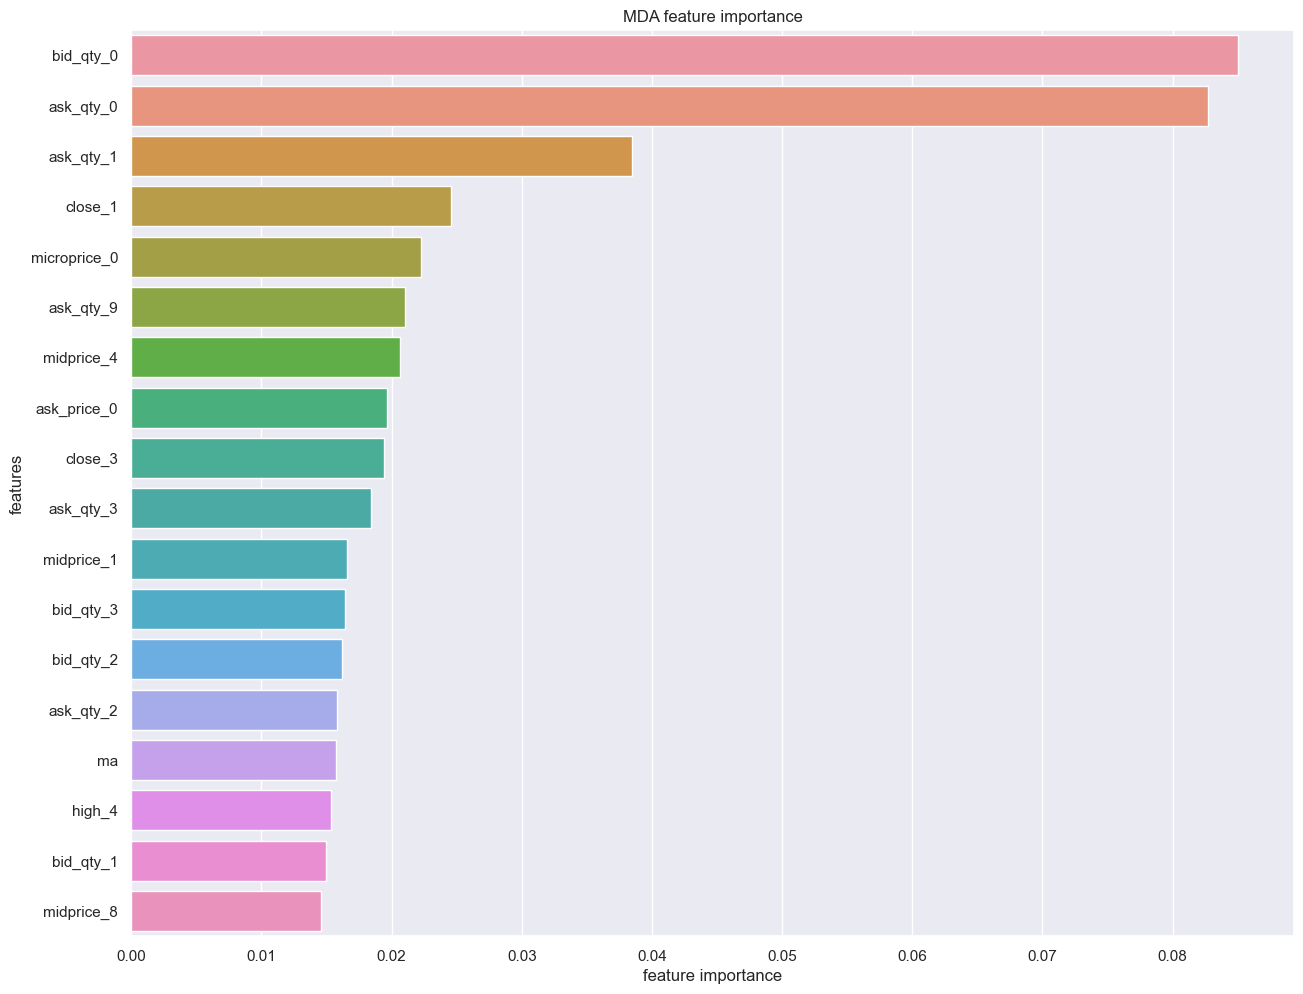

In [46]:
plot_feature_importance(base_est.feature_importances_, X_train_orthog.columns,'MDA',columns_to_take_mda*2)

In [47]:
# %% SFI
# MDA and MDI feature suffer from substitution effects. If two features are highly correlated,
# one of them will be considered as important while the other one will be redundant.
# SFI is a OOS feature importance estimator which doesn’t suffer from substitution effects because it estimates each feature importance separately.
print('SFI starting...')
sfi_feature_imp = single_feature_importance(base_est, X_train_orthog, y_input, cv_gen, scoring=accuracy_score)
sfi_best_columns = sfi_feature_imp.sort_values(by='mean', ascending=False)[:columns_to_take_sfi].index
sfi_best_columns = list(sfi_best_columns.values)
print(sfi_best_columns)

SFI starting...
['ask_qty_0', 'bid_qty_0', 'ask_qty_1', 'bid_price_6', 'ask_price_6', 'spread_6', 'bid_qty_1', 'spread_5', 'bid_price_5', 'ask_price_5', 'bid_price_0', 'ask_price_0', 'spread_0', 'bid_price_7', 'ask_price_7', 'spread_7', 'high_0', 'bid_qty_5']


In [48]:
# plot_feature_importance(base_est.feature_importances_, X_train_orthog.columns,'SFI',columns_to_take_sfi*2)

In [49]:

# selection_columns = set(private_state_columns+mda_best_columns + sfi_best_columns + mdi_best_columns)
selection_columns = set(mda_best_columns + sfi_best_columns + mdi_best_columns)
print('feature_importance_input finished to %d columns' % len(selection_columns))

feature_importance_input finished to 30 columns


In [50]:
selection_columns

{'ask_price_0',
 'ask_price_5',
 'ask_price_6',
 'ask_price_7',
 'ask_qty_0',
 'ask_qty_1',
 'ask_qty_4',
 'bid_price_0',
 'bid_price_5',
 'bid_price_6',
 'bid_price_7',
 'bid_qty_0',
 'bid_qty_1',
 'bid_qty_5',
 'close_0',
 'close_4',
 'high_0',
 'last_close_price_1',
 'last_close_price_4',
 'last_close_price_5',
 'low_0',
 'low_3',
 'ma',
 'midprice_5',
 'midprice_8',
 'midprice_9',
 'spread_0',
 'spread_5',
 'spread_6',
 'spread_7'}

In [52]:
len(selection_columns)

30

In [51]:
dill.dump_session(session_filename)